# Sentinel-2 indices

**Sentinel-2**<br>
Sentinel-2 is a passive optical multispectral satellite mission which can image the Earth surface using 13 different spectral bands from the visible to the short-wave infrared parts of the spectrum$^{[1]}$.<br>
In the table below the 13 different bands are listed with their band numer, a description, the center wavelength from the elecromagnetic spectrum and the spatial resolution. As an aid the number to call the different bands using this Python script is added (Python starts counting at 0).

| Sentinel-2 band | Description     | Central wavelength [nm] | Resolution [m] | No. to load in script |
|:----------------|:----------------|:------------------------|:---------------|:----------------------|
| B01             | Coastal aerosol | 443                     | 60             | 0                     |
| B02             | Blue            | 490                     | 10             | 1                     |
| B03             | Green           | 560                     | 10             | 2                     |
| B04             | Red             | 665                     | 10             | 3                     |
| B05             | Veg. red edge   | 705                     | 20             | 4                     |
| B06             | Veg. red edge   | 740                     | 20             | 5                     |
| B07             | Veg. red edge   | 783                     | 20             | 6                     |
| B08             | NIR             | 842                     | 10             | 7                     |
| B8A             | Veg. red edge   | 865                     | 20             | 8                     |
| B09             | Water vapour    | 945                     | 60             | 9                     |
| B10             | SWIR cirrus     | 1375                    | 60             | 10                    |
| B11             | SWIR            | 1610                    | 20             | 11                    |
| B12             | SWIR            | 2190                    | 20             | 12                    |


### Loading and inspecting the data

For this demo a Sentinel-2 image taken on the 23. August 2024 over Davos was already downloaded and cut to a smaller spatial area than the original downloaded data tile (due to storage and computational reasons). The filename tells us which satellite of the constellation took the picture ("S2B" stands for Sentinel-2B) at which date (20240823) and time (T101559 means 10:15:59 UTC).

In [16]:
# Load packages necessary for the script
import warnings
warnings.filterwarnings('ignore') # ignores the runtime warnings happening when dividing by 0 (they are not printed in the output)
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Read in the Sentinel-2 demo file from the data folder
with rasterio.open('Data/S2B_20240823T101559_davos.tif') as src:
    s2_image = src.read()

If we look at the data we just loaded, we see that the satellite image is just a ndarray. This means that each of the 13 spectral bands is stored as a separate array of pixel values stacked together to one big layer stack or ndarray. Imagine a tower of 13 pizza boxes where each box has x- and y-coordinates and is filled with the values of the respective spectral band.

In [ ]:
s2_image

We can select one of those pizza boxes (spectral bands) and display the values in a histogram. This way we can get an overview of the distribution of values within the selected band. If we want to look at the NIR band (B08) we have to call the 7th array in the ndarray we loaded (see table above column "No. to load in script" for reference).

In [ ]:
# Plot a histogram of one band
# -flatten is used to store all values in the array into a vector to be able to plot the histogram
# -bins allows to change the number of bins, e.g. how wide the bars will be in the histogram
plt.hist(s2_image[7].flatten(), bins=100)                           # initialize the histogram
plt.title('Histogram of values in the selected band', fontsize=16)  # add title
plt.xlabel('Band value')                                            # add axis labels
plt.ylabel('Count')
plt.show()

In the generated histogram we can notice two things:<br>
1. The band value range is very wide, reaching from 0 to 10'000 (and not 0 to 1 as we would expect from reflectance). This is due to the storage of the float numbers of the reflectance values in the file. To restore the original reflectance values we have to divide the values by 10'000 again.
2. There are a lot of 0-values. In Sentinel-2 images the value of 0 is used as the NaN value. This can happen at edges from e.g. cropping the image or at places with very low received signal. For visualization purposes we can replace the 0s to Nan.

In [17]:
# Divide by 10'000 to get reflectance between 0 and 1
s2_image = s2_image/10000

# Fill 0 with NaN to help with visualizing
s2_image_nan = s2_image.copy()
s2_image_nan[s2_image_nan == 0] = np.nan

### Visualizing the data

**Single band**<br>
With the help of "plt.imshow" we can visualize the reflectance data from each band spatialy, i.e., as an image. We can also color all the NaN values we saw in the histogram in a different color. If the bands are changed, different pixels within the image (e.g., in the lake) will be indicated in red (e.g. B08). By changing the band number the change in spatial resolution can be observed (e.g., B08 = 10m, B8A = 20m, B09 = 60m). To change the visualized band change the number in the square brackets: s2_image[x].

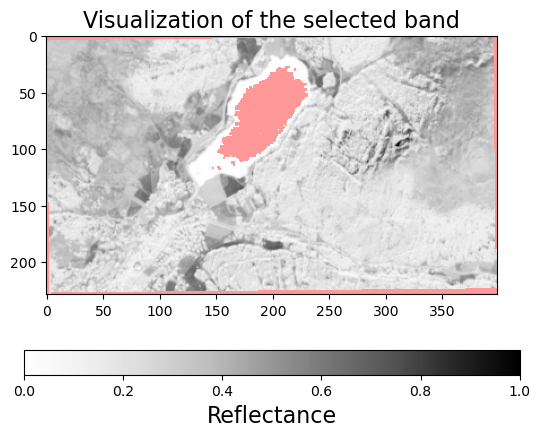

In [52]:
# Make a figure of a single band
cmap = plt.get_cmap('Greys')                            # define the colormap as greyscale
cmap.set_bad(color='red', alpha=0.4)                    # define the color for the NaN pixels

# Select/change the spectral band
plt.imshow(s2_image_nan[7], cmap=cmap, vmin=0, vmax=1)  # plot the desired band e.g. B08=[7]

plt.title('Visualization of the selected band', fontsize=16) # add a title
cbar = plt.colorbar(orientation='horizontal')           # generate a colorbar
cbar.set_label('Reflectance', fontsize=16)              # add a label to the colorbar
plt.show()                                              # display the figure

**True color RGB composite**<br>
To get the true color RGB image we are used to, we first have to stack the red, green and blue bands into a layer stack so that plt.imshow knows what to display. If we display the image like that it is very dark and does not have enough contrast to interpret it visually.


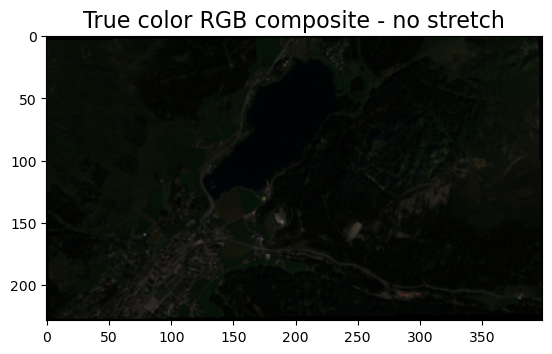

In [36]:
# Display original values as an RGB image
# Generate a layer stack from the RGB bands (B04, B03, B02)
rgb_composite = np.stack([s2_image[3], s2_image[2], s2_image[1]], axis=-1)

# Figure
plt.imshow(rgb_composite)
plt.title('True color RGB composite - no stretch', fontsize=16)
plt.show()

To make is look nicer we can clip the border or outlier values and normalize the data using the new minimum and maximum values. Here we use the 1% and 99% percentile to define the outliers in the data and use these new min. and max. values to scale the remaining data (gives the new stack "clipped_rgb"). Additionally, we normalize the data using the new min. and max. values to get the "rgb_norm", which we then use for the figure.<br>
**!!!This stretched and normalized data is only for visualization. We can not use it for further analysis!!!**

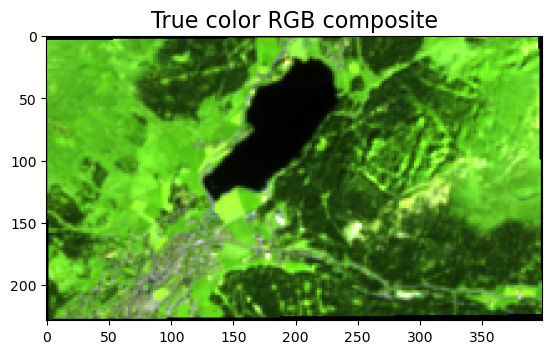

In [39]:
# Display the stretched and normalized data as an RGB image
# Generate a layer stack from the RGB bands (B04, B03, B02)
rgb_composite = np.stack([s2_image[3], s2_image[2], s2_image[1]], axis=-1)

# Scaling the data by clipping outliers
p_low, p_high = np.percentile(rgb_composite, (1, 99))   # use e.g. the 1- and 99-percentile as min and max values
clipped_rgb = np.clip(rgb_composite, p_low, p_high)     # clip the outliers defined above

# Normalizing the clipped data to make the image less dark
rgb_norm = ((clipped_rgb - clipped_rgb.min()) / (clipped_rgb.max() - clipped_rgb.min()))

# Figure
plt.imshow(rgb_norm)
plt.title('True color RGB composite', fontsize=16)
plt.show()

### Image analysis using spectral indices

By combining bands from different parts of the spectrum, in so-called spectral indices, information about the Earth surface, such as vegetation greenness and canopy water content, can be derived$^{[2]}$. This method relays on the fact that the desired phenomena to observe has a different effect on different parts of the spectrum. Using normalized difference indices we use an affected spectral band and a not affected one as reference to detect the desired phenomena (e.g., canopy water content).

**Normalized difference vegetation index - NDVI**<br>
The normalized difference vegetation index (NDVI) was developed by Tucker et al. in 1970tes and is widely used to estimate the green vegetation$^{[3]}$. The index normalizes green leaf scattering in NIR with chlorophyll absorption in red wavelengths and uses the following formula$^{[4]}$:<br>

$NDVI := \frac {NIR - red}{NIR + red} = \frac {B08 - B04}{B08 + B04}$ <br>

The NDVI is defined to have a value range of -1 to 1. Negative values correspond to water bodies (see lake surface), values close to 0 correspond to no-vegetation areas such as rock, snow, and urban. With increasing NDVI values the proportion of green vegetation also increases$^{[4, 5]}$.

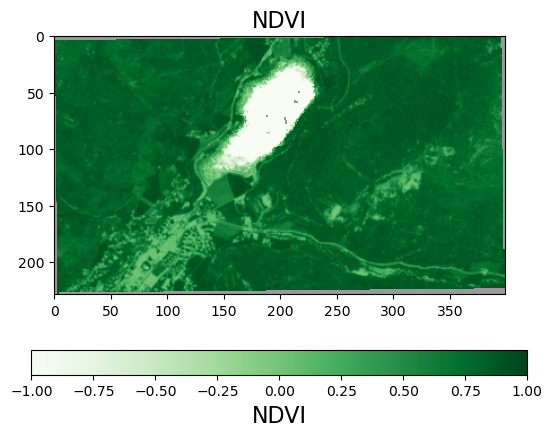

In [19]:
# Calculate the NDVI
# B04 = 3, B08 = 7
ndvi = (s2_image[7]-s2_image[3])/(s2_image[7]+s2_image[3])  # implement the NDVI formula from above

# Figure
cmap = plt.get_cmap('Greens')                   # select a meaningful colormap
cmap.set_bad(color='black', alpha=0.4)          # not valid pixels (both bands are 0) are displayed in grey
plt.imshow(ndvi, cmap=cmap, vmin=-1, vmax=1)    # plot the figure with value range -1 to 1 (NDVI is defined that way)
plt.title('Green vegetation', fontsize=16)      # add a title
cbar = plt.colorbar(orientation='horizontal')   # generate a colorbar
cbar.set_label('NDVI', fontsize=16)             # add a label to the colorbar
plt.show()                                      # display the figure

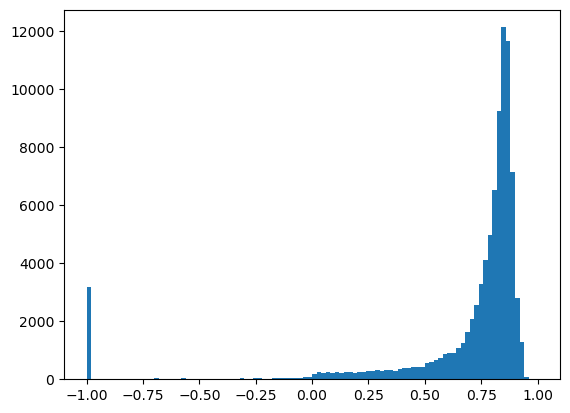

In [21]:
# Display the NDVI values in a histogram
plt.hist(ndvi.flatten(), bins=100)                  # initialize the histogram
plt.title('Histogram of NDVI values', fontsize=16)  # add title
plt.xlabel('NDVI')                                  # add axis labels
plt.ylabel('Count')
plt.show()

**Normalized difference moisture index - NDMI**<br>
The normalized difference moisture index (NDMI) was developed by Gao et al. in the 1990is and is used to estimate the vegetation water content or moisture$^{[6]}$ and is widely used for drought monitoring. The index used the different absorption features of water in leaves in the NIR and SWIR part of the spectrum$^{[7]}$.
It is calculated using bands in the NIR (B08) and SWIR (B11) region of the spectrum $^{[8]}$:<br>

$NDMI := \frac {NIR - SWIR}{NIR + SWIR} = \frac {B08 - B11}{B08 + B11}$ <br>

Note: NDWI index is often used synonymously with the NDMI index, often using NIR-SWIR combination as one of the two options. Gao$^{[6]}$ also called the index NDWI. NDMI seems to be consistently described using NIR-SWIR combination. As the indices with these two combinations work very differently, with NIR-SWIR highlighting differences in water content of leaves, and GREEN-NIR highlighting differences in water content of water bodies, we have decided to separate the indices on our repository as NDMI using NIR-SWIR, and NDWI using GREEN-NIR$^{[8]}$ (quote from Sentinel-Hub).

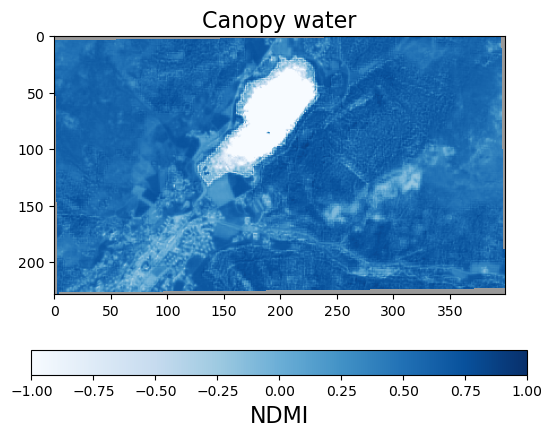

In [32]:
# Calculate the NDMI
# B08 = 7, B11 = 11
ndmi = (s2_image[7]-s2_image[11])/(s2_image[7]+s2_image[11])    # implement the NDWI formula from above

# Figure
cmap = plt.get_cmap('Blues')                    # define a colormap
cmap.set_bad(color='black', alpha=0.4)          # not valid pixels (both bands are 0) are displayed in grey
plt.imshow(ndmi, cmap=cmap, vmin=-1, vmax=1)    # plot the figure with value range -1 to 1 (NDMI is defined that way)
plt.title('Canopy water', fontsize=16)          # add a title
cbar = plt.colorbar(orientation='horizontal')   # generate a colorbar
cbar.set_label('NDMI', fontsize=16)             # add a label to the colorbar
plt.show()                                      # display the figure

NDMI values below 0 can indicate water stress (if vegetation is present), values above 0.4 indicate no water stress in the vegetation$^{[9]}$. The highest NDMI values in our image can be found in the forest where we have a lot of vegetation to store water in the canopy. The lake surface has a value of -1 indicating a non-vegetation surface. This is a bit counter-intuitive as we would expect a moisture or water index to be high over a large water body. To detect open water bodies we need to use a different water index.<br>

**Normalized difference water index (NDWI)**<br>
During the same time as Gao et al. developed their NDMI, McFeeters developed the normalized difference water index (NDWI) to detect water bodies $^{[10]}$. Water bodies absorb a lot of light in the visible domain (they appear dark), therefore the index uses the band combination of green and NIR $^{[11]}$:<br>

$NDWI := \frac {green - SWIR}{green + SWIR} = \frac {B03 - B08}{B03 + B08}$ <br> 

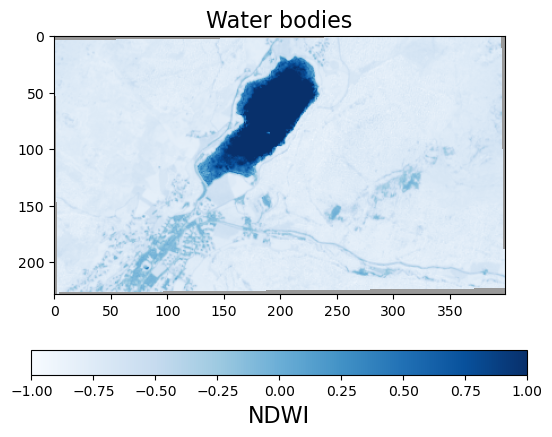

In [37]:
# Calculate the NDWI
# Waterbody detection by McFeeters using bands 3 (green) and 8A (NIR) -> modification of normalised difference water index (MNDWI)

# B03 = 2, B08 = 7
ndwi = (s2_image[2]-s2_image[7])/(s2_image[2]+s2_image[7])

# Figure
cmap = plt.get_cmap('Blues')                    # define a colormap
cmap.set_bad(color='black', alpha=0.4)          # not valid pixels (both bands are 0) are displayed in grey
plt.imshow(ndwi, cmap=cmap, vmin=-1, vmax=1)    # plot the figure with value range -1 to 1 (NDWI is defined that way)
plt.title('Water bodies', fontsize=16)          # add a title
cbar = plt.colorbar(orientation='horizontal')   # generate a colorbar
cbar.set_label('NDWI', fontsize=16)             # add a label to the colorbar
plt.show()                                      # display the figure

NDWI values above 0 indicate potential water bodies or flooding. The lake and river are clearly visible. However, some of the urban area has also high values. This is due to the sensitivity of the index to build structure as well as water$^{[12]}$.<br>

This example nicely illustrate that we need to think about the limitations of the used method in interpreting the calculated index images!

*Literature*<br>
$^{[1]}$: https://en.wikipedia.org/wiki/Sentinel-2<br>
$^{[2]}$: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel/sentinel-2/<br>
$^{[3]}$: Tucker, C.J., 1979. Red and photographic infrared linear combinations for monitoring vegetation. Remote Sensing of Environment 8, 127–150.<br>
$^{[4]}$: https://custom-scripts.sentinel-hub.com/sentinel-2/ndvi/<br>
$^{[5]}$: https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index<br>
$^{[6]}$: Gao, B., 1996. NDWI—A normalized difference water index for remote sensing of vegetation liquid water from space. Remote Sens. Environ. 58, 257–266.<br>
$^{[7]}$: Colombo, R., Meroni, M., Marchesi, A., Busetto, L., Rossini, M., Giardino, C., Panigada, C., 2008. Estimation of leaf and canopy water content in poplar plantations by means of hyperspectral indices and inverse modeling. Remote Sens. Environ. 112, 1820–1834.<br>
$^{[8]}$: https://custom-scripts.sentinel-hub.com/sentinel-2/ndmi/<br>
$^{[9]}$: https://eos.com/make-an-analysis/ndmi/<br>
$^{[10]}$: McFeeters, S.K., 1996. The use of the Normalized Difference Water Index (NDWI) in the delineation of open water features. Int. J. Remote Sens. 17, 1425–1432.<br>
$^{[11]}$: https://custom-scripts.sentinel-hub.com/sentinel-2/ndwi/<br>
$^{[12]}$: https://eos.com/make-an-analysis/ndwi/<br>

